# Rat Reinforcement Learning

---
```
: 22 July 2024
: zachcolinwolpe@gmail.com
```
---

In [1]:
import pandas as pd
import numpy as np
import scipy.io
import logging
import pprint
import os

from process_data.extract_matlab_data import load_processed_data

In [2]:
from src.rescorla_wagner_model import (RoscorlaWagner)
from src.rescorla_wagner_model_plots import (RescorlaWagnerPlots)
from src.rescorla_wagner_model_simulation import (RescorlaWagnerSimulate)
from src.rescorla_wagner_model_diagnostics import (RoscorlaWagerModelDiagnostics)

In [3]:
from src.helpers import log_rat_metadata, log_sequence_data, load_config

---
## Load Data
---

In [4]:
# load yaml config
_config = load_config('config.yaml')

# fetch file locations
_processed_data_loc = _config['processed_data']['location']
_data_file = _config['processed_data']['rat_experiment']['trials']
_metadata_file = _config['processed_data']['rat_experiment']['metadata']

In [5]:
# load data
data = load_processed_data(_processed_data_loc)


# load data
data = load_processed_data(_processed_data_loc)

# extact sequence data
rat_sequence_data = data[_data_file]
log_sequence_data(rat_sequence_data)


# Examine metadata
meta_data = data[_metadata_file]
log_rat_metadata(meta_data)



--------------------------------------------------------------- 
meta_data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 571 entries, 0 to 570
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ratID        571 non-null    int64 
 1   SessionType  571 non-null    object
 2   SessionNum   571 non-null    int64 
 3   CondNum      571 non-null    int64 
 4   ReleMode     571 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 22.4+ KB
None

Example:
   ratID  SessionType  SessionNum  CondNum  ReleMode
0   4151  IDS_BL_Easy           1        1         1
1   4151  IDS_BL_Easy           2        1         1
---------------------------------------------------------------

    ---------------------------------------------------------------
    No. Rats (IDs):     15
    ---------------------------------------------------------------
    
             No. Experiments per SessionType
SessionType                   

-----
# Fit RW Model to Rat Data
-----


In [7]:
StimCode = rat_sequence_data['StimCode']
RespCode = rat_sequence_data['RespCode']


In [10]:
[(ratID, sessionID, sessionNum) for (ratID, sessionID, sessionNum) in StimCode.keys()]
for (ratID, sessionID, sessionNum), data in StimCode.items():
    print(f"Rat ID: {ratID}, Session ID: {sessionID}, Session Number: {sessionNum}")
    print(data)
    print("")
    break

Rat ID: 4151, Session ID: IDS_BL_Easy, Session Number: 0
[0. 1. 0. 1. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 0. 1. 1. 0. 1. 0. 1. 0.
 1. 0. 1. 0. 0. 1. 0. 1. 0. 1. 1. 0. 1. 0. 1. 0. 0. 1. 1. 0. 1. 0. 0. 1.
 1. 0. 1. 0. 1. 0. 0. 1. 1. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 1. 0. 1. 1. 0.
 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 1. 0. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 1. 0.
 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 1. 0. 0. 1. 0. 1. 1. 0. 0. 1. 0. 1.
 1. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 1. 1. 0. 0. 1. 1. 0. 0. 1. 1. 0. 1. 0.
 0. 1. 0. 1. 0. 1. 1. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 1. 1. 0. 1. 0. 0. 1.
 0. 1. 1. 0. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 1. 0. 1. 0. 1. 0. 0. 1. 0. 1.
 1. 0. 0. 1. 1. 0. 1. 0. 0. 1. 0. 1. 1. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 1.
 0. 1. 1. 0. 0. 1. 0. 1. 1. 0. 0. 1. 1. 0. 0. 1. 1. 0. 0. 1. 0. 1. 1. 0.
 1. 0. 0. 1. 1. 0. 1. 0. 0. 1. 1. 0. 0. 1. 1. 0. 0. 1. 0. 1. 1. 0. 1. 0.
 1. 0. 0. 1. 0. 1. 0. 1. 1. 0. 1. 0. 1. 0. 1. 0. 0. 1. 1. 0. 0. 1. 1. 0.
 0. 1. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 1. 1. 0. 1. 0. 1. 0. 

In [128]:
unique_session_types = np.unique([i[1] for i in StimCode.keys()])
unique_session_types

array(['EDS', 'EDS_BL_Easy', 'EDS_BL_Hard', 'IDS', 'IDS_BL_Easy', 'RE',
       'Stair'], dtype='<U11')

In [130]:
qsd = QuerySequenceData(StimCode, RespCode)
KEY = (4151, 'IDS_BL_Easy', 0)
qsd.query(ratID=4151, sessionType='IDS_BL_Easy', sessionNum=0)
_stimCode, _respCode = qsd.return_experiment_vectors(ratID=4151, sessionType='IDS_BL_Easy', sessionNumber=0)
_reward, _action = qsd.infer_action_reward_pairs(_respCode)


len(_reward)

382

In [103]:

# execute

qsd = QuerySequenceData(StimCode, RespCode)
RAT_ID = 4151
KEY = (RAT_ID, 'IDS_BL_Easy', None)

_stimCode, _respCode = qsd.query(
    ratID=KEY[0],
    sessionType=KEY[1],
    sessionNum=KEY[2])
# _reward, _action = qsd.infer_action_reward_pairs(_respCode)


# Extract stimData & resp
# assuming sorting isn't required.
def extract_stim_resp_data(_stimCode, _respCode):
    stimData = []
    respData = []
    for (_stimKey, _stimData), (_respKey, _respData) in zip(_stimCode.items(), _respCode.items()):
        stimData.extend(_stimData)
        respData.extend(_respData)
    return stimData, respData

stimData, respData = extract_stim_resp_data(_stimCode, _respCode)
# concatenate all IDS or EDS sessions

In [132]:
_action, _reward = qsd.infer_action_reward_pairs(respData)
# stimData, respData

# Try All Experiment Types

In [143]:
qsd = QuerySequenceData(StimCode, RespCode)
RAT_ID = 4151

unique_session_types = np.unique([i[1] for i in StimCode.keys()])
unique_rat_id = np.unique([i[0] for i in StimCode.keys()])

results = {'ratID': [], 'sessionType': [], 'sessionNum': [], 'avg_reward': []}
for rat_id, session_type in zip(unique_rat_id, unique_session_types):

    # for session_num in np.unique([i[2] for i in StimCode.keys()]):
    #     KEY = (rat_id, session_type, session_num)
    #     _stimCode, _respCode = qsd.query(
    #         ratID=KEY[0], sessionType=KEY[1], sessionNum=KEY[2]
    #         )
        # _reward, _action = qsd.infer_action_reward_pairs(_respCode)



    
    KEY = (rat_id, session_type, None)

    _stimCode, _respCode = qsd.query(
        ratID=KEY[0], sessionType=KEY[1], sessionNum=KEY[2]
        )
    # _reward, _action = qsd.infer_action_reward_pairs(_respCode)


    stimData, respData = extract_stim_resp_data(_stimCode, _respCode)
    _action, _reward = qsd.infer_action_reward_pairs(respData)
    # stimData, respData
    # 
    _reward

    avg_reward = np.mean(_reward)
    results['ratID'].append(rat_id)
    results['sessionType'].append(session_type)
    results['sessionNum'].append(None)
    results['avg_reward'].append(avg_reward)


 

pd.DataFrame(results)

,ratID,sessionType,sessionNum,avg_reward
0,422,EDS,None,0.499889
1,422,EDS,None,0.499889
2,422,EDS,None,0.499889
3,422,EDS,None,0.499889
4,422,EDS,None,0.499889
...,...,...,...,...
177,4154,Stair,None,0.500000
178,4154,Stair,None,0.500000
179,4154,Stair,None,0.500000
180,4154,Stair,None,0.500000


In [138]:
# Calculate the probability of reward per bin
# def reward_prob(reward, bin_size=20):
#     """
#     Calculate the probability of reward per bin. If bin=None, return the probability of reward for the entire sequence.
    
#     """

# X, probs = RoscorlaWagerModelDiagnostics.calc_prob_of_success(np.array(_reward), bin_size=None)
# import plotly.express as px

# fig = px.line(x=X, y=probs)
# fig.show()

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [117]:
_action
pd.DataFrame({'StimCode': stimData, 'RespCode': respData, 'Reward': _reward, 'Action': _action})
np.unique(stimData)


array([0., 1.], dtype=float32)

In [122]:
# fetch processed data
# data = load_processed_data('./data/processed_data/')

param_fits, BIC = RoscorlaWagner.fit_rescorla_wagner_model_n_times(
    action_vector=_action,
    reward_vector=_reward,
    alpha_range=np.linspace(0,1,10),
    theta_range=np.linspace(1,25,10),
    alpha_bound=(0,1),
    theta_bound=(0,50))

100%|██████████| 10/10 [00:02<00:00,  4.80it/s]

Neg Log Likelihood fit complete.
alpha_hat = 0.00, theta_hat = 1.00
BIC = 3040.27


In [123]:
msg = """
    Fit Parameters:
    ---------------
        : alpha: %.2f
        : theta: %.2f
    """ % (param_fits[0], param_fits[1])
print(msg)
param_fits


    Fit Parameters:
    ---------------
        : alpha: 0.00
        : theta: 1.00
    


array([0., 1.])

In [124]:
Q_stored, predicted_action_vector, action_probabilities = \
   RoscorlaWagerModelDiagnostics.generate_Q_values(
      param_fits,
      action_vector=_action,
      reward_vector=_reward)


<module 'matplotlib.pyplot' from '/Users/zachwolpe/miniforge3/envs/mlxgo/lib/python3.12/site-packages/matplotlib/pyplot.py'>

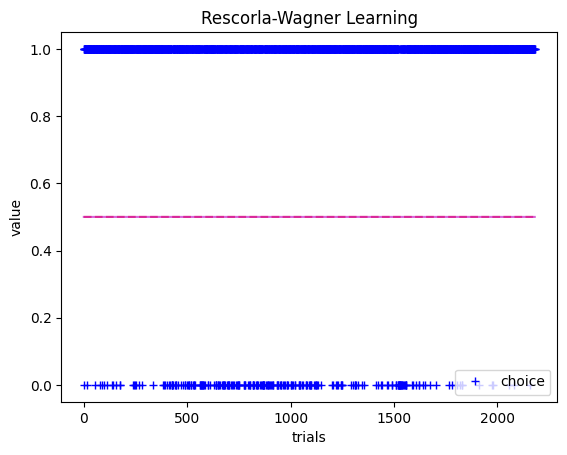

In [125]:
# Infered
RescorlaWagnerPlots.plot_Q_estimates(Q_values=Q_stored, choice_vector=_action)

In [127]:

x_vector, prob_of_success = RoscorlaWagerModelDiagnostics.calc_prob_of_success(_reward, bin_size=50)


import plotly.graph_objects as go

frac = 0.4
x_loess, y_loess = RoscorlaWagerModelDiagnostics.fit_loess(x_vector, prob_of_success, frac=frac)
fig = RescorlaWagnerPlots.plot_metric(x_vector, prob_of_success)
fig.add_trace(go.Scatter(x=x_loess, y=y_loess, mode='lines', line_color='red', name=f'loess frac:{frac}'))
fig.show()